# Анализ источников новостей

### Summary iz.ru

1. Датасет содержит **86 600** текстов из них **1289** дублей. 
2. Содержит **33** рубрики из которых **10** (Мир, Общество, Политика, Экономика, Страна, Спорт, Культура, Армия, Наука, Интернет) покрывают **99%** датасета.  
3. Не пустые столбцы - **date, url, topics, authors, title, text**. Столбец authors заполнен в 28%.
4. В среднем текст содержит **222** слова. 
5. Первая дата публикации - **2001-06-28**, последняя - **2017-12-26**. Пропущены некоторые года - 2006, 2010.
6. В **2017** опубликованно **42%** текстов, 2009 - **17%**, 2011 - **10%**. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from pymystem3 import Mystem
from string import punctuation

Загрузим датасет iz. Одновременно сделаем преобразование даты из строки

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [3]:
data_iz = pd.read_csv('/Users/marinadorosh/Desktop/openDS/iz.csv', 
                      escapechar='\\', 
                      parse_dates=['date'],
                      quotechar='\"', 
                      error_bad_lines=False,
                      index_col=False,)

b'Skipping line 61517: expected 17 fields, saw 20\n'


In [4]:
# Проверим преобразование
data_iz.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [5]:
data_iz.shape

(86600, 16)

In [6]:
# Так выглядет датасет IZ
data_iz.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2017-01-24 18:24:00,https://iz.ru/699785/nataliia-portiakova/chtob...,-,Мир,Наталия Портякова,Чтобы помнили,В Европейском парламенте (ЕП) 24 января прошла...,-,-,-,-,-,-,-,-,-
1,2017-11-23 23:30:00,https://iz.ru/695670/izru-poluchil-premiiu-runeta,-,Пресс-релизы,NaN,IZ.ru получил премию Рунета,"IZ.ru стал победителем в номинации «Культура, ...",-,-,-,-,-,-,-,-,-
2,2017-11-25 23:49:47,https://iz.ru/675449/2017-11-25/chislo-mashin-...,-,Общество,NaN,Число машин с «мигалками» увеличили в Совфеде,"Президент России Владимир Путин подписал указ,...",-,-,-,-,-,-,-,-,-
3,2017-11-25 23:47:03,https://iz.ru/675448/2017-11-25/kudrin-zaiavil...,-,Экономика,NaN,Кудрин заявил о подготовке проекта развития РФ...,"Бывший министр финансов России, глава Центра с...",-,-,-,-,-,-,-,-,-
4,2017-11-25 23:46:48,https://iz.ru/675447/2017-11-25/gollandetc-kup...,-,Мир,NaN,Голландец купил акварель Гитлера за 75 центов,"Женщина, пожелавшая остаться неизвестной, отда...",-,-,-,-,-,-,-,-,-


In [7]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_iz.text.duplicated().sum())

data_iz = data_iz.drop_duplicates(subset='text')

Кол-во одинаковых текстов: 1289


In [8]:
# Выясним в каким столбцах есть пустые данные
data_iz.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [9]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_iz['text'].isnull().sum())
data_iz[data_iz['text'].isnull()]

Кол-во строк с значением NaN в столбце "Text" =  1


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
330,2017-01-01,https://iz.ru/654049/video/odnopolye-braki,-,Общество,NaN,однополые браки,NaN,-,-,-,-,-,-,-,-,-


In [10]:
#Удалим эти строки
data_iz['text'].dropna(inplace=True)

In [11]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_iz['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [12]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_iz['authors'].isnull().sum())
print('Процент статтей без автора: ', np.round(data_iz['authors'].isnull().sum()/data_iz.shape[0] *100, 2))

Кол-во строк с значением NaN в столбце "authors" =  61672
Процент статтей без автора:  72.29


Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [13]:
print('edition: ',data_iz['edition'].unique())
print('reposts_fb: ', data_iz['reposts_fb'].unique())
print('reposts_vk: ',data_iz['reposts_vk'].unique())
print('reposts_ok: ',data_iz['reposts_ok'].unique())
print('reposts_twi: ',data_iz['reposts_twi'].unique())
print('reposts_lj: ',data_iz['reposts_lj'].unique())
print('reposts_tg: ',data_iz['reposts_tg'].unique())
print('likes: ',data_iz['likes'].unique())
print('views: ',data_iz['views'].unique())
print('comm_count: ',data_iz['comm_count'].unique())

edition:  ['-']
reposts_fb:  ['-']
reposts_vk:  ['-']
reposts_ok:  ['-']
reposts_twi:  ['-']
reposts_lj:  ['-']
reposts_tg:  ['-']
likes:  ['-']
views:  ['-']
comm_count:  ['-']


Значений нет, можно удалять

### Рубрики IZ

In [14]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_iz.topics.unique().shape)
data_iz['topics'].unique()

Количество рубрик =  (33,)


array(['Мир', 'Пресс-релизы', 'Общество', 'Экономика', 'Спорт', 'Наука',
       'Политика', 'Культура', 'Армия', 'Страна', 'Авто', 'Интернет',
       'Образование', 'Потребительский рынок', 'Новости компаний',
       'День в истории', 'Туризм', 'Вкусно!', 'Россия - регионы',
       'Недвижимость', 'Китай', 'Art Briz', 'Здоровье', 'Стиль',
       'Инновации', 'Происшествия', 'Финансы', 'Транспорт',
       'Среда для жизни', 'Профсоюзы', 'Спецпроекты', 'День Победы',
       'Финансовая грамотность'], dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [15]:
data_iz.groupby(['topics'])['topics'].count().sort_values(ascending=False)

topics
Мир                       23482
Общество                  22868
Политика                   9217
Экономика                  7764
Страна                     7657
Спорт                      5733
Культура                   4952
Армия                      1150
Наука                      1126
Интернет                    899
Туризм                       76
Здоровье                     47
Авто                         44
Инновации                    42
Транспорт                    38
Россия - регионы             38
День в истории               27
Недвижимость                 26
Образование                  26
Новости компаний             19
Финансы                      18
Среда для жизни              14
Китай                        12
Art Briz                      9
Вкусно!                       7
Стиль                         4
Потребительский рынок         3
Пресс-релизы                  3
Профсоюзы                     3
Финансовая грамотность        2
Спецпроекты                   2
Д

###  Анализ дат

In [16]:
print('Минимальная дата в датасете:', data_iz.date.min())
print('Максимальная дата в датасете:', data_iz.date.max())


Минимальная дата в датасете: 2001-06-28 16:51:00
Максимальная дата в датасете: 2017-12-26 23:58:25


In [19]:
data_iz['month'] = data_iz.date.apply(lambda x: x.month)
data_iz['year'] = data_iz.date.apply(lambda x: x.year)
df = data_iz.groupby(['year', 'month']).text.nunique().reset_index()
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)
df.columns = ['year', 'month', 'nunique_text', 'month_year']
df = df[df.nunique_text>10]
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head(10)

,month_year,nunique_text
71,07-2017,8979
75,12-2017,8866
72,09-2017,6112
73,10-2017,4003
69,05-2017,3618
66,09-2016,3473
37,04-2009,2547
38,05-2009,2482
31,04-2008,2392
39,06-2009,2348


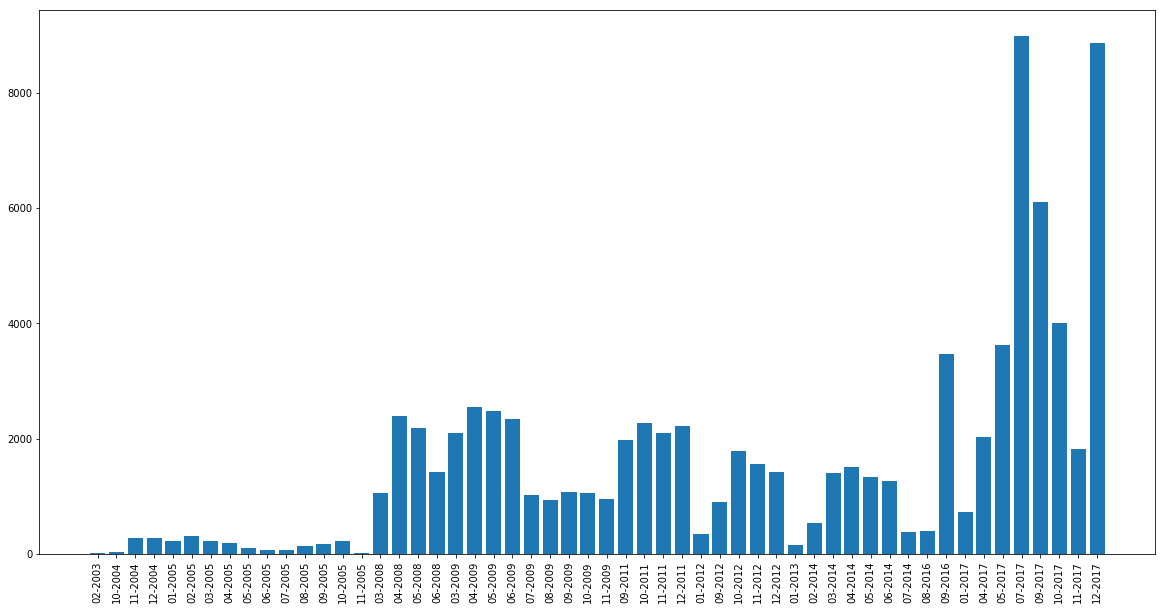

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
plt.show()

In [22]:
mystem = Mystem() 
stopwords = open('../nlp/preprocessing/stopwords.txt', 'r')
stopwords = stopwords.read().split('\n')
stopwords += ['br', 'также', 'весь', 'это', 'из', 'какой то', 'млн', 'рубль', 
              'именно', 'поэтому', 'либо', 'пока', 'например', 'поскольку', 'iz','ru'
             ]

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [23]:
data_iz['preprocessed_text'] = data_iz.text.apply(lambda x:preprocess_text(x) if pd.isna(x)==False else '')

TypeError: sequence item 330: expected str instance, float found

In [24]:
texts = ' '.join(data_iz.preprocessed_text.tolist())

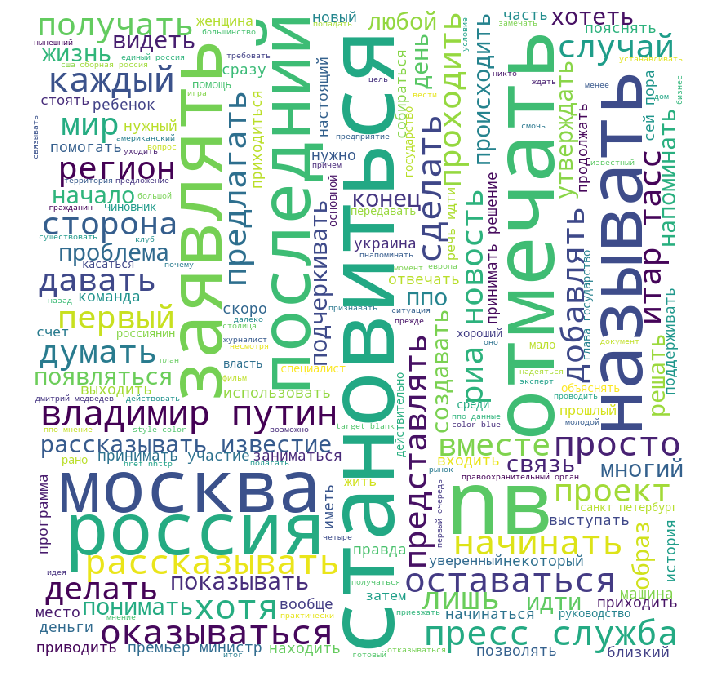

In [25]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(texts) 
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()